In [26]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rasterio.plot import show
from config import aux_dir

import warnings
warnings.filterwarnings('ignore')

from config import climo_dir, models, scenarios, metrics

In [28]:
climo_fps = list(climo_dir.glob("*.tif"))
delta_files = climo_fps = list(climo_dir.glob("*delta*.tif"))

def group_files(files):
    # Dictionary to store the groups
    groups = {}
    
    for metric in metrics:
        for scenario in scenarios:
            # The group key is the model, scenario, and metric
            key = f"{scenario}_{metric}"
            # Filter the files that match the key
            matching_files = [file for file in files if key in file.name]
            # Split the matching files into subgroups of 9
            groups[key] = matching_files

    return groups

def prep_for_ridgeline(file_group):
    arrs = []
    model_names = []
    
    scenario, files = list(file_group.items())[0]
    for file in files:
        # Extract the model name from the file name
        model = file.name.split('_')[0]

        # Read the GeoTIFF file
        with rio.open(file) as src:
            array = src.read(1)

        # Flatten the array and remove NaN values
            array = array[array != src.nodata]

        array = array.flatten()
        model_names.append(model)
        arrs.append(array)
        
    df = pd.DataFrame()
    df["model"] = model_names
    df["array_data"] = arrs

    return df


def explode_dataframe(df):
    # Convert the array data into a list
    df['array_data'] = df['array_data'].apply(list)

    # Explode the DataFrame
    exploded_df = df.explode('array_data')

    # Rename the exploded column to 'value'
    exploded_df = exploded_df.rename(columns={'array_data': 'modeled climatology - daymet climatology'})

    return exploded_df


def create_ridge_plot(metric_df, title):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(metric_df, row="model", hue="model", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "modeled climatology - daymet climatology",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "modeled climatology - daymet climatology", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "modeled climatology - daymet climatology")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.suptitle(title)
    #plt.show()


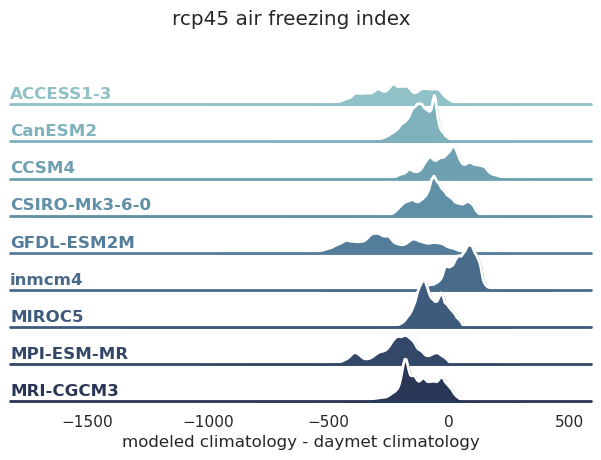

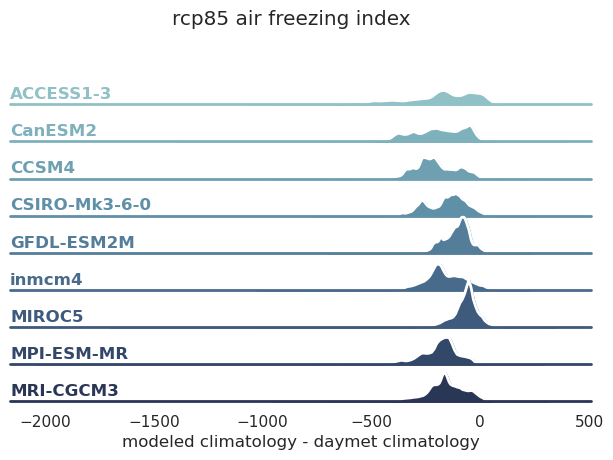

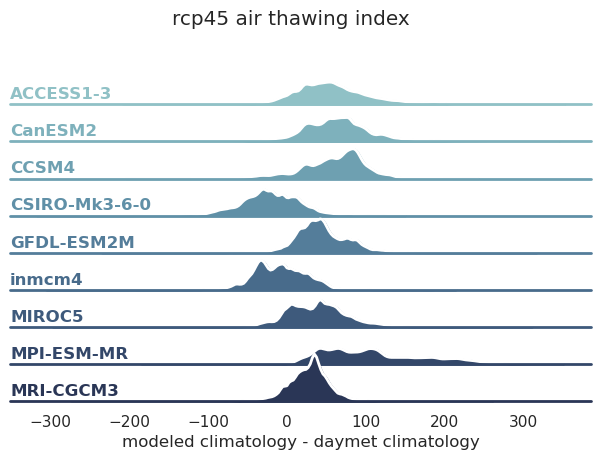

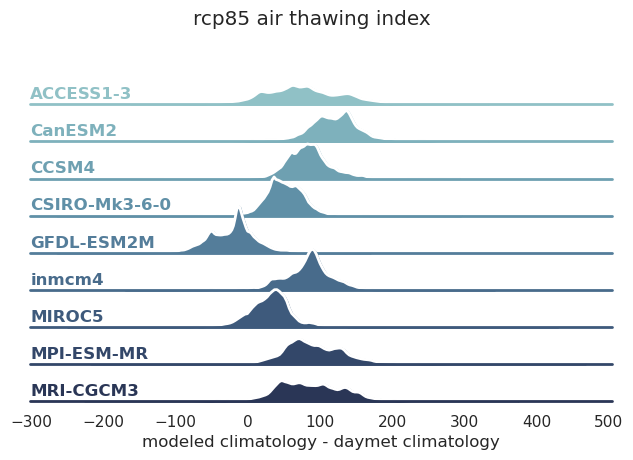

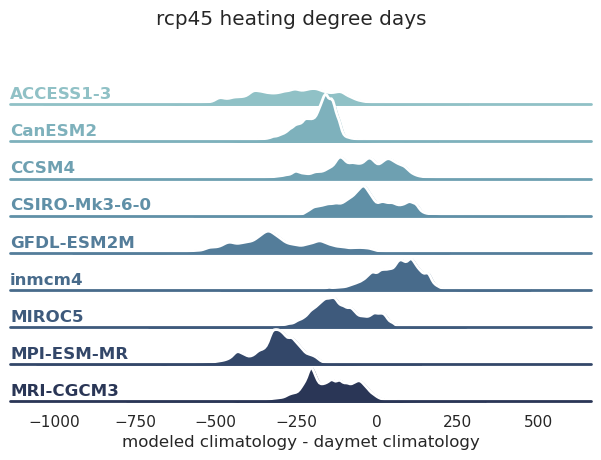

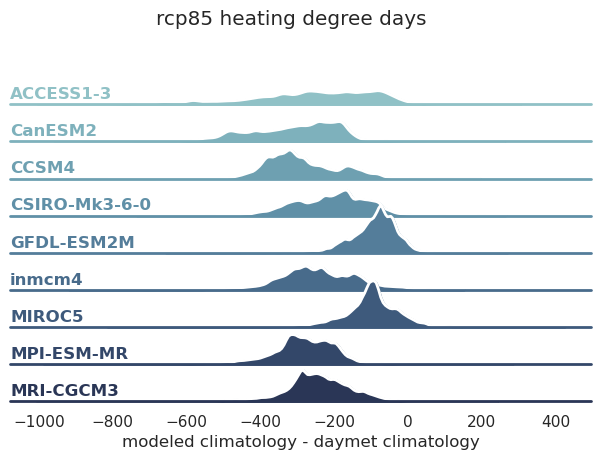

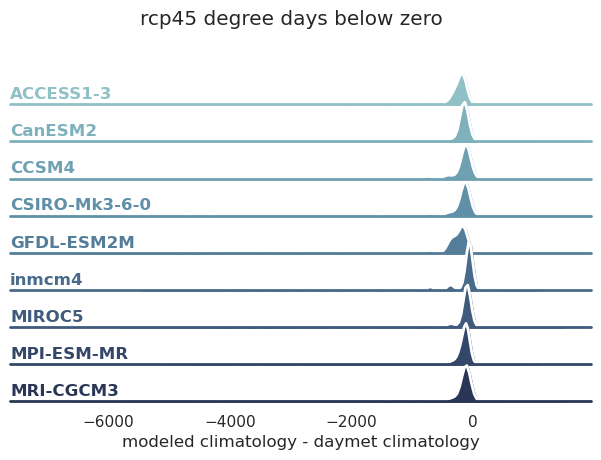

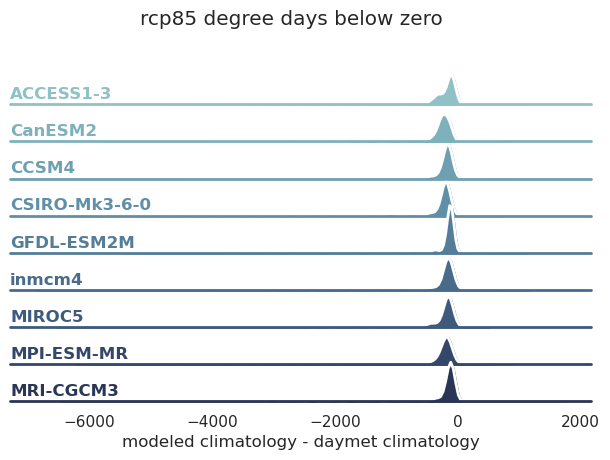

In [29]:
groups = group_files(delta_files)

for k, data in groups.items():
        title = k.replace("_", " ")
        df_for_ridgeline = explode_dataframe(prep_for_ridgeline({k: data}))
        create_ridge_plot(df_for_ridgeline, title)
        plt.savefig(aux_dir / f"{k}_ridgeline.png", bbox_inches="tight")

In [ ]:
def plot_maps(var):
    fig, axs = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True)
    var_fps = [x for x in climo_fps if var in x.name]
    
    arrs = []
    titles = []
    for ax in axs.flatten():
        i = np.random.randint(len(var_fps))
        fp = var_fps[i]
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            arrs.append(src.read(1))
        title = fp.name[0:-4]
        ax.set_title(title)
        titles.append(title)

    plt.show()
    
    return arrs, titles


def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)

    plt.show()
    
for var in metrics:
    arrs, titles = plot_maps(var)
    plot_histograms(arrs, titles)

In [40]:
s = "MIROC5_rcp45_heating_degree_days_1981_2010_climo_minus_daymet_delta"
t = s.replace("_", " ")
t = "MIROC5 RCP 4.5 heating degree days 1981-2010 climo minus Daymet 1981-2010 climo"
t

'MIROC5 RCP 4.5 heating degree days 1981-2010 climo minus Daymet 1981-2010 climo'

Let's check the deltas from the historical baseline

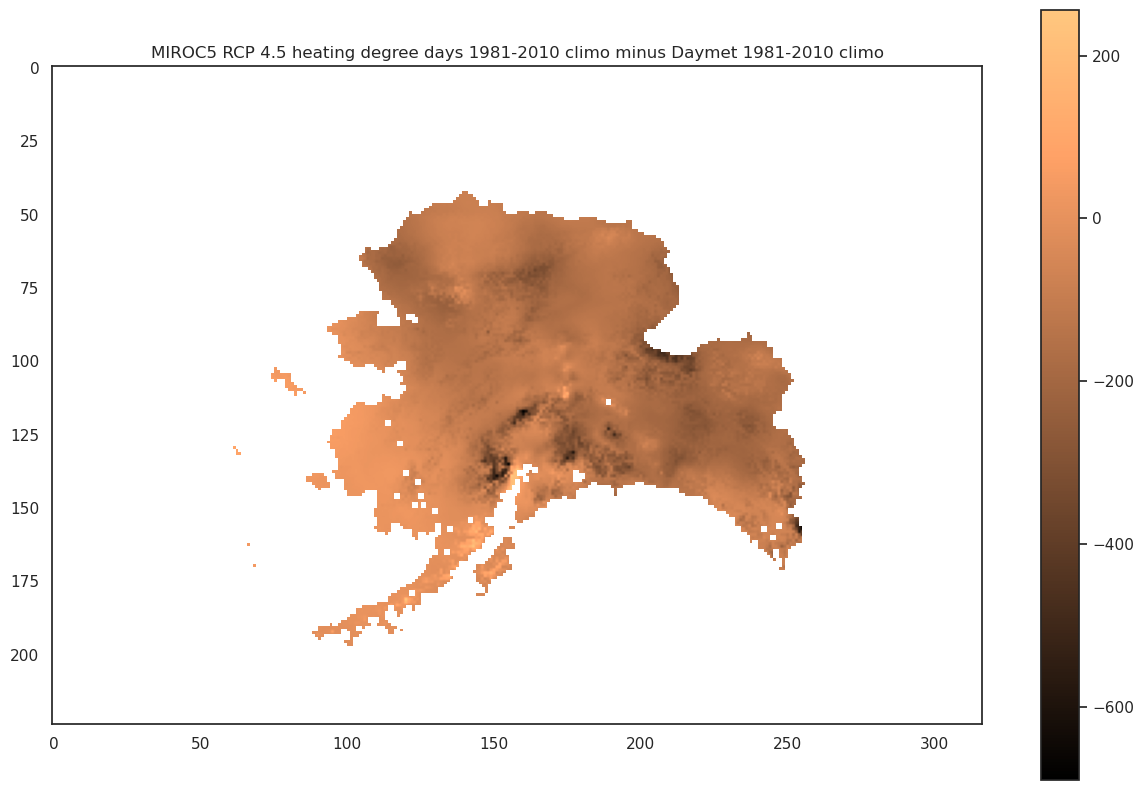

In [42]:
with rio.open(climo_dir / "MIROC5_rcp45_heating_degree_days_1981_2010_climo_minus_daymet_delta.tif") as src:
    img = src.read(1).astype(float)
    img[img == src.nodata] = np.nan
    fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the figure size here
    cax = ax.imshow(img, cmap='copper')
    ax.set_title(t)
    fig.colorbar(cax, ax=ax)
    plt.show()

In [ ]:
def plot_geotiff_violin(files):
    data = []
    labels = []
    for file in files:
        with rio.open(file) as src:
            band1 = src.read(1)
            # Flatten the 2D array to 1D for histogram
            band1 = band1.flatten()
            # Remove no data values if any exist
            band1 = 
            data.append(band1)
            labels.append(file.name.split("_")[0])
    plt.figure(figsize=(12,6))
    plt.title("RCP 8.5 Heating Degree Days: Difference from Daymet Historical Baseline")
    plt.suptitle("Comparing Modeled and Daymet 1981-2010 Normals")
    plt.ylabel("HDD (delta) F-days")
    sns.violinplot(data=data)
    plt.xticks(np.arange(len(files)), labels)
    plt.show()

plot_geotiff_violin(groups["rcp85_heating_degree_days"])